Imports 

In [ ]:

import IPython.display as ipd
import librosa
import noisereduce as nr
import numpy as np
import soundfile as sf
from pathlib import Path
import os
import torch
from torch.utils.data import Dataset
from glob import glob

import matplotlib.pyplot as plt
import IPython.display as ipd

import shutil
import pandas as pd
from sklearn.model_selection import train_test_split



Cuda test

In [ ]:
import torch
print(torch.cuda.is_available())         
print(torch.cuda.get_device_name(0))    

Dataset infomation

In [ ]:
#add code for 

Dataset Split and Oversampling

In [ ]:
import os
import pandas as pd
import shutil
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

# Config
RANDOM_SEED = 42
BASE_DIR = "datasets/release_in_the_wild"
META_CSV = os.path.join(BASE_DIR, "meta.csv")
WAV_DIR = BASE_DIR

OUTPUT_DIRS = {
    "train": os.path.join(BASE_DIR, "train"),
    "val": os.path.join(BASE_DIR, "val"),
    "test": os.path.join(BASE_DIR, "test")
}

for path in OUTPUT_DIRS.values():
    os.makedirs(path, exist_ok=True)

df = pd.read_csv(META_CSV)
df["file"] = df["file"].str.strip()
df["label"] = df["label"].str.strip()
df["speaker"] = df["speaker"].str.strip()

df_40_percent, _ = train_test_split(
    df,
    train_size=0.4,
    random_state=RANDOM_SEED,
    stratify=df["label"]
)

train_df, temp_df = train_test_split(
    df_40_percent,
    test_size=0.30,
    random_state=RANDOM_SEED,
    stratify=df_40_percent["label"]
)

val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    random_state=RANDOM_SEED,
    stratify=temp_df["label"]
)

spoof_train = train_df[train_df["label"] == "spoof"]
bonafide_train = train_df[train_df["label"] == "bona-fide"]

spoof_upsampled = resample(
    spoof_train,
    replace=True,
    n_samples=len(bonafide_train),
    random_state=RANDOM_SEED
)

train_df = pd.concat([bonafide_train, spoof_upsampled]).sample(frac=1.0, random_state=RANDOM_SEED)

#copy not move 
def move_files(subset_df, split_name):
    for _, row in subset_df.iterrows():
        src = os.path.join(WAV_DIR, row["file"])
        dst = os.path.join(OUTPUT_DIRS[split_name], row["file"])
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        if os.path.exists(src):
            shutil.copy(src, dst)

# Move files
#move_files(train_df, "train")
#move_files(val_df, "val")
#move_files(test_df, "test")

# Save metadata
#train_df.to_csv(os.path.join(BASE_DIR, "train_meta.csv"), index=False)
#val_df.to_csv(os.path.join(BASE_DIR, "val_meta.csv"), index=False)
#test_df.to_csv(os.path.join(BASE_DIR, "test_meta.csv"), index=False)

# Summary
def count_files(folder_path):
    return len([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])

print("✔ 40% of dataset sampled and split into train/val/test (70/15/15).")
print("✔ Spoof samples oversampled in train set only.")
print(f"Train files: {count_files(OUTPUT_DIRS['train'])}")
print(f"Val files: {count_files(OUTPUT_DIRS['val'])}")
print(f"Test files: {count_files(OUTPUT_DIRS['test'])}")

# Show label distribution in each set
print("\nLabel Distribution:")
print("Train:\n", train_df["label"].value_counts())
print("Val:\n", val_df["label"].value_counts())
print("Test:\n", test_df["label"].value_counts())




Data Preprocessing 

In [ ]:
import numpy as np
from pathlib import Path
from tqdm import tqdm


import librosa

# Preprocess raw audio
def preprocess_audio(y, sr, target_duration=6.0, apply_preemphasis=False, coef=0.5, normalise='rms'):
    y, _ = librosa.effects.trim(y)

    if apply_preemphasis:
        y = librosa.effects.preemphasis(y, coef=coef)

    if normalise == 'rms':
        rms = np.sqrt(np.mean(y**2))
        y = y / (rms + 1e-6)
    elif normalise == 'peak':
        y = y / (np.max(np.abs(y)) + 1e-6)

    target_length = int(sr * target_duration)
    if len(y) < target_length:
        y = np.pad(y, (0, target_length - len(y)))
    else:
        y = y[:target_length]

    return y

Feature Extraction (With saving feature to save time for future tests)

In [ ]:
# Main extraction + saving
def extract_and_save_all(input_root, output_root, sr=22050, target_duration=6.0, apply_preemphasis=False, coef=0.5, normalise='rms'):
    input_root = Path(input_root)
    output_root = Path(output_root)

    for split in ["train", "val","test"]:  
        input_folder = input_root / split
        output_base = output_root / f"preprocessed_{split}"

        print(f"Looking in: {input_folder}")
        wav_files = [f for f in input_folder.glob("*.wav")]
        print(f"Found {len(wav_files)} files in '{split}'")

        for wav_file in tqdm(wav_files):
            try:
                y, _ = librosa.load(wav_file, sr=sr)
                y = preprocess_audio(y, sr, target_duration, apply_preemphasis, coef, normalise)

                base_name = wav_file.stem + ".npy"

                feature_dict = {
                    "mel_spectrogram": librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128),
                    "mfcc": librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20),
                    "chroma": librosa.feature.chroma_stft(y=y, sr=sr),
                    "tonnetz": librosa.feature.tonnetz(y=librosa.effects.harmonic(y), sr=sr),
                    "spectral_contrast": librosa.feature.spectral_contrast(y=y, sr=sr),
                    "spectral_centroid": librosa.feature.spectral_centroid(y=y, sr=sr),
                    "pitch": librosa.yin(y, fmin=50, fmax=300, sr=sr),
                    "energy": librosa.feature.rms(y=y),
                    "zcr": librosa.feature.zero_crossing_rate(y),
                    "onset_strength": librosa.onset.onset_strength(y=y, sr=sr)
                }

                for feature_name, data in feature_dict.items():
                    out_path = output_base / feature_name / base_name
                    out_path.parent.mkdir(parents=True, exist_ok=True)
                    np.save(out_path, data.astype(np.float32))

            except Exception as e:
                print(f"[ERROR] {wav_file.name}: {e}")

#Run the feature extraction
#extract_and_save_all("datasets/release_in_the_wild", "datasets/release_in_the_wild")











Data visualisation

In [ ]:

def load_audio(path, sr=22050):
    y, _ = librosa.load(path, sr=sr)
    return y

def show_waveform(y, sr, title="Waveform"):
    plt.figure(figsize=(10, 2))
    librosa.display.waveshow(y, sr=sr)
    plt.title(title)
    plt.tight_layout()
    plt.show()

def show_mel_spectrogram(y, sr, title="Mel Spectrogram"):
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    mel_db = librosa.power_to_db(mel_spec, ref=np.max)

    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mel_db, sr=sr, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.tight_layout()
    plt.show()

def compare_audio(original_path, fake_path, apply_preprocessing=False, sr=22050):
    print(f" Original: {original_path}")
    y_real = load_audio(original_path, sr=sr)
    y_fake = load_audio(fake_path, sr=sr)

    if apply_preprocessing:
        y_real = preprocess_audio(y_real, sr, apply_preemphasis=True, normalise='rms')
        y_fake = preprocess_audio(y_fake, sr, apply_preemphasis=True, normalise='rms')

    # Waveform comparison
    show_waveform(y_real, sr, title="Real - Waveform")
    ipd.display(ipd.Audio(y_real, rate=sr))

    show_waveform(y_fake, sr, title="Fake - Waveform")
    ipd.display(ipd.Audio(y_fake, rate=sr))

    # Mel spectrogram comparison
    show_mel_spectrogram(y_real, sr, title="Real - Mel Spectrogram")
    show_mel_spectrogram(y_fake, sr, title="Fake - Mel Spectrogram")

real_audio_path = "datasets/release_in_the_wild/remaining_files/7.wav"

fake_audio_path = "datasets/release_in_the_wild/remaining_files/5.wav"

#compare_audio(real_audio_path, fake_audio_path, apply_preprocessing=False)
#compare_audio(real_audio_path, fake_audio_path, apply_preprocessing=True)




In [ ]:

# USE THIS VERSION TO TRAIN,TEST,VAL FOR RELEASE_IN_THE_WILD DATASET
import torch
from torch.utils.data import Dataset
import numpy as np
import os
import pandas as pd

import torch.nn.functional as F
class AudioFeatureDataset(Dataset):
    def __init__(self, meta_csv, feature_root,
                 features=['chroma', 'energy', 'mel_spectrogram', 'mfcc',
                           'onset_strength', 'pitch', 'spectral_centroid',
                           'spectral_contrast', 'tonnetz', 'zcr'],
                 target_shape=(128, 259)):  
        self.df = pd.read_csv(meta_csv)
        self.df["label"] = self.df["label"].str.strip().str.lower()
        self.feature_root = feature_root
        self.features = features
        self.label_map = {'bona-fide': 1, 'spoof': 0}
        self.target_shape = target_shape

    def __len__(self):
        return len(self.df)

    def pad_or_resize(self, tensor, target_shape):
        h, w = tensor.shape
        pad_h = target_shape[0] - h
        pad_w = target_shape[1] - w

        if pad_h < 0 or pad_w < 0:
            tensor = tensor[:target_shape[0], :target_shape[1]] 
        else:
            tensor = F.pad(tensor, (0, pad_w, 0, pad_h))  
        return tensor

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        file_id = os.path.splitext(row["file"])[0] + ".npy"
        label_raw = row["label"]
        if label_raw not in self.label_map:
            raise ValueError(f"Unknown label: '{label_raw}' at idx {idx}")
        label = self.label_map[label_raw]

        feature_arrays = []
        for feat in self.features:
            path = os.path.join(self.feature_root, feat, file_id) 
            if not os.path.exists(path):
                raise FileNotFoundError(f"Missing file: {path}")
            feature = np.load(path)
            tensor = torch.tensor(feature, dtype=torch.float32)
            if tensor.dim() == 1:
                tensor = tensor.unsqueeze(0)
            tensor = self.pad_or_resize(tensor, self.target_shape)
            feature_arrays.append(tensor)

        return (*feature_arrays, torch.tensor(label, dtype=torch.float32))






Model Architecture (DenseNN + Siamese)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DenseNeuralNetwork(nn.Module):
    def __init__(self, input_dim, output_dim=128):
        super(DenseNeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.bn1 = nn.BatchNorm1d(256)

        self.fc2 = nn.Linear(256, 256)
        self.bn2 = nn.BatchNorm1d(256)

        self.fc3 = nn.Linear(256, output_dim)
        self.bn3 = nn.BatchNorm1d(output_dim)

        self.dropout = nn.Dropout(0.3)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = self.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = self.relu(self.bn3(self.fc3(x)))
        return x



class SiameseMFCCBranch(nn.Module):
    def __init__(self):
        super(SiameseMFCCBranch, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(2)
        self.dropout = nn.Dropout(0.5)

        self.flattened_size = 128 * 32 * 64  
        self.fc = nn.Linear(self.flattened_size, 128)

    def forward(self, x):
        x = F.relu(self.conv1(x))       
        x = self.pool(F.relu(self.conv2(x)))  
        x = self.pool(F.relu(self.conv3(x)))  
        x = self.dropout(x)
        x = x.view(x.size(0), -1)        
        x = self.fc(x)                   
        return x


# Final Fusion Model
class AudioDeepfakeFusionModel(nn.Module):
    def __init__(self):
        super(AudioDeepfakeFusionModel, self).__init__()

        self.mfcc_branch = SiameseMFCCBranch()

        self.chroma_branch = DenseNeuralNetwork(input_dim=128)
        self.tonnetz_branch = DenseNeuralNetwork(input_dim=128)
        self.contrast_branch = DenseNeuralNetwork(input_dim=128)
        self.pitch_branch = DenseNeuralNetwork(input_dim=128)
        self.energy_branch = DenseNeuralNetwork(input_dim=128)
        self.zcr_branch = DenseNeuralNetwork(input_dim=128)
        self.onset_branch = DenseNeuralNetwork(input_dim=128)
        self.centroid_branch = DenseNeuralNetwork(input_dim=128)
        self.mel_spec_branch = DenseNeuralNetwork(input_dim=128)

        self.fusion_layer = nn.Sequential(
            nn.Linear(10 * 128, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
        )
        self.output_layer = nn.Linear(256, 1)

    def forward(self, mfcc, chroma, tonnetz, contrast, pitch, energy, zcr, onset, centroid, mel_spec):
        mfcc = mfcc.unsqueeze(1)  

        def pool(x): return x.mean(dim=-1)  

        mfcc_out = self.mfcc_branch(mfcc)
        chroma_out = self.chroma_branch(pool(chroma))
        tonnetz_out = self.tonnetz_branch(pool(tonnetz))
        contrast_out = self.contrast_branch(pool(contrast))
        pitch_out = self.pitch_branch(pool(pitch))
        energy_out = self.energy_branch(pool(energy))
        zcr_out = self.zcr_branch(pool(zcr))
        onset_out = self.onset_branch(pool(onset))
        centroid_out = self.centroid_branch(pool(centroid))
        mel_spec_out = self.mel_spec_branch(pool(mel_spec))

        fusion = torch.cat([
            mfcc_out, chroma_out, tonnetz_out, contrast_out,
            pitch_out, energy_out, zcr_out, onset_out, centroid_out, mel_spec_out
        ], dim=1)

        x = self.fusion_layer(fusion)
        return torch.sigmoid(self.output_layer(x))



Training Loop

In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

def train_model(model, train_loader, val_loader, epochs, lr, device):
    model = model.to(device)
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    history = {'train_loss': [], 'val_loss': [], 'val_acc': [], 'val_f1': []}

    for epoch in range(epochs):
        model.train()
        train_loss = 0

        for features, labels in train_loader:
            features, labels = features.to(device), labels.to(device).unsqueeze(1)
            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        model.eval()
        val_loss, all_preds, all_labels = 0, [], []

        with torch.no_grad():
            for features, labels in val_loader:
                features, labels = features.to(device), labels.to(device).unsqueeze(1)
                outputs = model(features)
                val_loss += criterion(outputs, labels).item()
                all_preds += outputs.cpu().numpy().flatten().tolist()
                all_labels += labels.cpu().numpy().flatten().tolist()

        all_preds_bin = [1 if p > 0.5 else 0 for p in all_preds]
        acc = np.mean(np.array(all_preds_bin) == np.array(all_labels))
        f1 = f1_score(all_labels, all_preds_bin)

        history['train_loss'].append(train_loss / len(train_loader))
       # history['val_loss'].append(val_loss / len(val_loader))
        #history['val_acc'].append(acc)
        #history['val_f1'].append(f1)

        print(f"[{epoch+1}/{epochs}] Train Loss: {train_loss:.4f}, #Val Loss: {val_loss:.4f}, Val Acc: {acc:.4f}, F1: {f1:.4f}")

    return model, history, all_labels, all_preds_bin

from sklearn.metrics import ConfusionMatrixDisplay

def plot_metrics(history):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    #plt.plot(history['val_loss'], label='Val Loss')
    plt.legend()
    plt.title("Loss over Epochs")

    plt.subplot(1, 2, 2)
    plt.plot(history['val_acc'], label='Accuracy')
    #plt.plot(history['val_f1'], label='F1 Score')
    plt.legend()
    plt.title("Accuracy & F1 Score")

    plt.tight_layout()
    plt.show()


def plot_conf_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Spoof', 'Bona-fide'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt
from tqdm import tqdm

def train_binary_classification_model(
    model, train_dataset, val_dataset,
    epochs=20, batch_size=32, learning_rate=1e-4,
    device='cuda' if torch.cuda.is_available() else 'cpu'
):
    model = model.to(device)
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    history = {
        'train_loss': [],
        'val_loss': [],
        'val_acc': [],
        'val_prec': [],
        'val_rec': [],
        'val_f1': []
    }

    for epoch in range(1, epochs + 1):
        model.train()
        train_preds = []
        train_trues = []
        train_loss = 0.0

        pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{epochs}")
        for batch in pbar:
            inputs = [b.to(device) for b in batch[:-1]]
            labels = batch[-1].float().to(device).unsqueeze(1)

            outputs = model(*inputs)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * labels.size(0)
            train_preds.extend((outputs > 0.5).int().cpu().numpy())
            train_trues.extend(labels.cpu().numpy())
            pbar.set_postfix({'Loss': loss.item()})

        avg_train_loss = train_loss / len(train_loader.dataset)
        history['train_loss'].append(avg_train_loss)

        # Validation
        model.eval()
        val_loss = 0
        val_preds = []
        val_trues = []

        with torch.no_grad():
            for batch in val_loader:
                inputs = [b.to(device) for b in batch[:-1]]
                labels = batch[-1].float().to(device).unsqueeze(1)

                outputs = model(*inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * labels.size(0)

                val_preds.extend((outputs > 0.5).int().cpu().numpy())
                val_trues.extend(labels.cpu().numpy())

        avg_val_loss = val_loss / len(val_loader.dataset)
        acc = accuracy_score(val_trues, val_preds)
        prec = precision_score(val_trues, val_preds)
        rec = recall_score(val_trues, val_preds)
        f1 = f1_score(val_trues, val_preds)

        history['val_loss'].append(avg_val_loss)
        history['val_acc'].append(acc)
        history['val_prec'].append(prec)
        history['val_rec'].append(rec)
        history['val_f1'].append(f1)

        print(f"\n[Validation] Loss: {avg_val_loss:.4f} | Acc: {acc:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f}")

    # Save model
    torch.save(model.state_dict(), "df_model.pth")
    print("\n Model saved to 'df_model.pth'")

    # Plot metric graphs
    plot_training_history(history)

    # Show confusion matrix for both splits
    show_confusion_matrix(train_trues, train_preds, title="Train Set")
    show_confusion_matrix(val_trues, val_preds, title="Validation Set")


def show_confusion_matrix(true_labels, pred_labels, title="Confusion Matrix"):
    cm = confusion_matrix(true_labels, pred_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Spoof", "Bona-fide"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix - {title}")
    plt.show()


def plot_training_history(history):
    plt.figure(figsize=(15, 6))

    # Loss
    plt.subplot(1, 3, 1)
    plt.plot(history['train_loss'], label="Train Loss")
    plt.plot(history['val_loss'], label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Loss over Epochs")

    # Accuracy & F1
    plt.subplot(1, 3, 2)
    plt.plot(history['val_acc'], label="Accuracy")
    plt.plot(history['val_f1'], label="F1 Score")
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.legend()
    plt.title("Accuracy & F1")

    # Precision & Recall
    plt.subplot(1, 3, 3)
    plt.plot(history['val_prec'], label="Precision")
    plt.plot(history['val_rec'], label="Recall")
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.legend()
    plt.title("Precision & Recall")

    plt.tight_layout()
    plt.show()






Cleaner Training and Classification code

In [ ]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve,
    confusion_matrix, ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt
from tqdm import tqdm

class BinaryClassifierTrainer:
    def __init__(
        self,
        model: nn.Module,
        train_dataset,
        val_dataset,
        batch_size: int = 32,
        lr: float = 1e-4,
        device: str = 'cuda' if torch.cuda.is_available() else 'cpu'
    ):
        self.device = device
        self.model = model.to(self.device)
        self.criterion = nn.BCELoss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
        self.train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        self.val_loader   = DataLoader(val_dataset,   batch_size=batch_size)
        
        # History including AUC & EER for both train and validation
        self.history = {
            'train_loss': [], 'train_acc': [], 'train_prec': [], 'train_rec': [], 'train_f1': [], 'train_auc': [], 'train_eer': [],
            'val_loss':   [], 'val_acc':   [], 'val_prec':   [], 'val_rec':   [], 'val_f1':   [], 'val_auc':   [], 'val_eer':   []
        }

    def _run_epoch(self, loader, train: bool):
        epoch_loss = 0.0
        all_probs, all_preds, all_labels = [], [], []

        if train:
            self.model.train()
        else:
            self.model.eval()

        iterable = tqdm(loader, desc='Training') if train else loader
        for batch in iterable:
            *inputs, labels = batch
            labels = labels.float().to(self.device).unsqueeze(1)
            inputs = [x.to(self.device) for x in inputs]

            with torch.set_grad_enabled(train):
                outputs = self.model(*inputs)
                loss = self.criterion(outputs, labels)

                if train:
                    self.optimizer.zero_grad()
                    loss.backward()
                    self.optimizer.step()

            epoch_loss += loss.item() * labels.size(0)
            probs = outputs.detach().cpu().numpy().flatten()
            preds = (probs > 0.5).astype(int)
            truths = labels.detach().cpu().numpy().flatten()

            all_probs.extend(probs.tolist())
            all_preds.extend(preds.tolist())
            all_labels.extend(truths.tolist())

        # Compute metrics
        avg_loss = epoch_loss / len(loader.dataset)
        acc  = accuracy_score(all_labels, all_preds)
        prec = precision_score(all_labels, all_preds, zero_division=0)
        rec  = recall_score(all_labels, all_preds, zero_division=0)
        f1   = f1_score(all_labels, all_preds, zero_division=0)
        auc  = roc_auc_score(all_labels, all_probs)
        
        # Equal Error Rate (EER)
        fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
        fnr = 1 - tpr
        idx = np.nanargmin(np.abs(fnr - fpr))
        eer = fpr[idx]

        return avg_loss, acc, prec, rec, f1, auc, eer, all_labels, all_preds

    def fit(self, epochs: int = 20):
        for epoch in range(1, epochs + 1):
            # Training epoch
            train_loss, train_acc, train_prec, train_rec, train_f1, train_auc, train_eer, _, _ = \
                self._run_epoch(self.train_loader, train=True)
            # Validation epoch
            val_loss, val_acc, val_prec, val_rec, val_f1, val_auc, val_eer, _, _ = \
                self._run_epoch(self.val_loader,   train=False)

            # Record history
            self.history['train_loss'].append(train_loss)
            self.history['train_acc'].append(train_acc)
            self.history['train_prec'].append(train_prec)
            self.history['train_rec'].append(train_rec)
            self.history['train_f1'].append(train_f1)
            self.history['train_auc'].append(train_auc)
            self.history['train_eer'].append(train_eer)

            self.history['val_loss'].append(val_loss)
            self.history['val_acc'].append(val_acc)
            self.history['val_prec'].append(val_prec)
            self.history['val_rec'].append(val_rec)
            self.history['val_f1'].append(val_f1)
            self.history['val_auc'].append(val_auc)
            self.history['val_eer'].append(val_eer)

            # Print summary
            print(
                f"Epoch {epoch}/{epochs} | "
                f"Train Loss: {train_loss:.4f} | Acc: {train_acc:.4f} | Prec: {train_prec:.4f} | Rec: {train_rec:.4f} | "
                f"F1: {train_f1:.4f} | AUC: {train_auc:.4f} | EER: {train_eer:.4f} || "
                f"Val Loss: {val_loss:.4f} | Acc: {val_acc:.4f} | Prec: {val_prec:.4f} | Rec: {val_rec:.4f} | "
                f"F1: {val_f1:.4f} | AUC: {val_auc:.4f} | EER: {val_eer:.4f}"
            )

        # Save final model
        torch.save(self.model.state_dict(), "df_model.pth")
        print("Model saved to 'df_model.pth'")

    def plot_history(self):
        # You can extend this method to include plots for AUC and EER if desired
        plt.figure(figsize=(15, 5))

        # Loss
        plt.subplot(1, 3, 1)
        plt.plot(self.history['train_loss'], label='Train Loss')
        plt.plot(self.history['val_loss'],   label='Val Loss')
        plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.title('Loss')

        # Accuracy & F1
        plt.subplot(1, 3, 2)
        plt.plot(self.history['train_acc'], label='Train Acc')
        plt.plot(self.history['val_acc'],   label='Val Acc')
        plt.plot(self.history['train_f1'],  label='Train F1')
        plt.plot(self.history['val_f1'],    label='Val F1')
        plt.xlabel('Epoch'); plt.ylabel('Score'); plt.legend(); plt.title('Acc & F1')

        # Precision, Recall, AUC
        plt.subplot(1, 3, 3)
        plt.plot(self.history['train_prec'], label='Train Prec')
        plt.plot(self.history['val_prec'],   label='Val Prec')
        plt.plot(self.history['train_rec'],  label='Train Rec')
        plt.plot(self.history['val_rec'],    label='Val Rec')
        plt.plot(self.history['train_auc'],  label='Train AUC')
        plt.plot(self.history['val_auc'],    label='Val AUC')
        plt.xlabel('Epoch'); plt.ylabel('Score'); plt.legend(); plt.title('Prec, Rec & AUC')

        plt.tight_layout()
        plt.show()

    def plot_confusion(self, true_labels, pred_labels, title='Confusion Matrix'):
        cm = confusion_matrix(true_labels, pred_labels)
        disp = ConfusionMatrixDisplay(cm, display_labels=['Spoof', 'Bona‑fide'])
        disp.plot(cmap=plt.cm.Blues)
        plt.title(title)
        plt.show()




In [ ]:
train_dataset = AudioFeatureDataset(
    meta_csv="datasets/release_in_the_wild/train_meta.csv",
    feature_root="datasets/release_in_the_wild/preprocessed_train",
    features=[
        'mfcc', 'chroma', 'tonnetz', 'spectral_contrast',
        'pitch', 'energy', 'zcr', 'onset_strength',
        'spectral_centroid','mel_spectrogram'
    ]
)
val_dataset = AudioFeatureDataset(
    meta_csv="datasets/release_in_the_wild/val_meta.csv",
    feature_root="datasets/release_in_the_wild/preprocessed_val",
    features=[
        'mfcc', 'chroma', 'tonnetz', 'spectral_contrast',
        'pitch', 'energy', 'zcr', 'onset_strength',
        'spectral_centroid','mel_spectrogram'
    ]
)
model = AudioDeepfakeFusionModel()
trainer = BinaryClassifierTrainer(
    model,
    train_dataset,
    val_dataset,
    batch_size=32,
    lr=0.001,
    device='cuda'  
)

#comment out if you dont want to run 

trainer.fit(epochs=50)
trainer.plot_history()

_, _, _, _, _, _, _, val_labels, val_preds = \
    trainer._run_epoch(trainer.val_loader, train=False)

trainer.plot_confusion(val_labels, val_preds, title='Validation set Confusion')

_, _, _, _, _, _, _, train_labels, train_preds = trainer._run_epoch(trainer.train_loader, train=False)

trainer.plot_confusion(train_labels, train_preds, title='train Set Confusion Matrix')




Run Train + Val 

In [ ]:

train_dataset = AudioFeatureDataset(
    meta_csv="datasets/release_in_the_wild/train_meta.csv",
    feature_root="datasets/release_in_the_wild/preprocessed_train",
    features=[
        'mfcc', 'chroma', 'tonnetz', 'spectral_contrast',
        'pitch', 'energy', 'zcr', 'onset_strength', 'spectral_centroid','mel_spectrogram'
    ]
)
val_dataset = AudioFeatureDataset(
    meta_csv="datasets/release_in_the_wild/val_meta.csv",
    feature_root="datasets/release_in_the_wild/preprocessed_val",
    features=[
        'mfcc', 'chroma', 'tonnetz', 'spectral_contrast',
        'pitch', 'energy', 'zcr', 'onset_strength', 'spectral_centroid','mel_spectrogram'
    ]
)
model = AudioDeepfakeFusionModel()

train_binary_classification_model(
    model,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    epochs=50,
    batch_size=32,
    learning_rate=0.001
 
)

In [ ]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
)
from scipy.optimize import brentq
from scipy.interpolate import interp1d
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import torch
from torch.utils.data import DataLoader

def evaluate_on_test_set(model, test_dataset, batch_size=32, device='cuda' if torch.cuda.is_available() else 'cpu'):
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    model.eval()
    model.to(device)

    all_probs = []
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Testing"):
            inputs = [b.to(device) for b in batch[:-1]]
            labels = batch[-1].float().to(device).unsqueeze(1)

            outputs = model(*inputs)
            probs = torch.sigmoid(outputs).squeeze().cpu().numpy()
            preds = (probs > 0.5).astype(int)

            all_probs.extend(probs)
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())

    # Convert to numpy arrays
    all_labels = np.array(all_labels).astype(int)
    all_preds = np.array(all_preds)
    all_probs = np.array(all_probs)

    # Metrics

    acc  = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, zero_division=0)
    rec  = recall_score(all_labels, all_preds, zero_division=0)
    f1   = f1_score(all_labels, all_preds, zero_division=0)
    auc  = roc_auc_score(all_labels, all_probs)


    # Compute EER
    fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
    fnr = 1 - tpr
    eer = brentq(lambda x: 1. - x - interp1d(fpr, tpr)(x), 0., 1.)

    # Print metrics
    print("\nTest Set Evaluation:")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1 Score:  {f1:.4f}")
    print(f"AUC:       {auc:.4f}")
    print(f"EER:       {eer:.4f}")

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Spoof", "Bona-fide"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix - Test Set")
    plt.show()



# Load saved weights
model = AudioDeepfakeFusionModel()
model.load_state_dict(torch.load("df_model.pth", map_location=torch.device('cpu'), weights_only=True))

#RELEASE IN THE WILD TEST
release_in_wild_test_dataset = AudioFeatureDataset(
    meta_csv="datasets/release_in_the_wild/test_meta.csv",
    feature_root="datasets/release_in_the_wild/preprocessed_test",
    features=[
        'mfcc', 'chroma', 'tonnetz', 'spectral_contrast',
        'pitch', 'energy', 'zcr', 'onset_strength', 'spectral_centroid', 'mel_spectrogram'
    ]
)

evaluate_on_test_set(model, release_in_wild_test_dataset)





Evaluation of model
For 2-sec dataset

Looking in: datasets\evaluation\for-2sec\for-2seconds\testing\real
Found 544 files in 'testing/real'


Processing real: 100%|██████████| 544/544 [01:48<00:00,  5.00it/s]


Looking in: datasets\evaluation\for-2sec\for-2seconds\testing\fake
Found 544 files in 'testing/fake'


Testing:   3%|▎         | 1/34 [00:01<01:01,  1.85s/it]

--> In Linear, after flatten: (32, 128)


Testing:   6%|▌         | 2/34 [00:03<01:00,  1.89s/it]

--> In Linear, after flatten: (32, 128)


Testing:   9%|▉         | 3/34 [00:05<00:54,  1.76s/it]

--> In Linear, after flatten: (32, 128)


Testing:  12%|█▏        | 4/34 [00:07<00:53,  1.80s/it]

--> In Linear, after flatten: (32, 128)


Testing:  15%|█▍        | 5/34 [00:08<00:50,  1.73s/it]

--> In Linear, after flatten: (32, 128)


Testing:  18%|█▊        | 6/34 [00:10<00:48,  1.72s/it]

--> In Linear, after flatten: (32, 128)
--> In Linear, after flatten: (32, 128)


Testing:  24%|██▎       | 8/34 [00:14<00:45,  1.76s/it]

--> In Linear, after flatten: (32, 128)


Testing:  26%|██▋       | 9/34 [00:16<00:46,  1.87s/it]

--> In Linear, after flatten: (32, 128)


Testing:  29%|██▉       | 10/34 [00:17<00:43,  1.82s/it]

--> In Linear, after flatten: (32, 128)


Testing:  32%|███▏      | 11/34 [00:19<00:40,  1.74s/it]

--> In Linear, after flatten: (32, 128)
--> In Linear, after flatten: (32, 128)


Testing:  38%|███▊      | 13/34 [00:22<00:35,  1.71s/it]

--> In Linear, after flatten: (32, 128)
--> In Linear, after flatten: (32, 128)


Testing:  44%|████▍     | 15/34 [00:26<00:33,  1.76s/it]

--> In Linear, after flatten: (32, 128)
--> In Linear, after flatten: (32, 128)


Testing:  50%|█████     | 17/34 [00:30<00:29,  1.75s/it]

--> In Linear, after flatten: (32, 128)


Testing:  53%|█████▎    | 18/34 [00:31<00:27,  1.71s/it]

--> In Linear, after flatten: (32, 128)


Testing:  56%|█████▌    | 19/34 [00:33<00:25,  1.67s/it]

--> In Linear, after flatten: (32, 128)
--> In Linear, after flatten: (32, 128)


Testing:  62%|██████▏   | 21/34 [00:36<00:21,  1.68s/it]

--> In Linear, after flatten: (32, 128)


Testing:  65%|██████▍   | 22/34 [00:38<00:20,  1.72s/it]

--> In Linear, after flatten: (32, 128)


Testing:  68%|██████▊   | 23/34 [00:40<00:19,  1.73s/it]

--> In Linear, after flatten: (32, 128)


Testing:  71%|███████   | 24/34 [00:41<00:16,  1.70s/it]

--> In Linear, after flatten: (32, 128)
--> In Linear, after flatten: (32, 128)


Testing:  76%|███████▋  | 26/34 [00:45<00:14,  1.75s/it]

--> In Linear, after flatten: (32, 128)


Testing:  79%|███████▉  | 27/34 [00:47<00:12,  1.82s/it]

--> In Linear, after flatten: (32, 128)


Testing:  82%|████████▏ | 28/34 [00:49<00:11,  1.85s/it]

--> In Linear, after flatten: (32, 128)


Testing:  85%|████████▌ | 29/34 [00:51<00:09,  1.81s/it]

--> In Linear, after flatten: (32, 128)
--> In Linear, after flatten: (32, 128)


Testing:  91%|█████████ | 31/34 [00:55<00:05,  1.93s/it]

--> In Linear, after flatten: (32, 128)


Testing:  94%|█████████▍| 32/34 [00:57<00:03,  1.96s/it]

--> In Linear, after flatten: (32, 128)


Testing:  97%|█████████▋| 33/34 [00:59<00:01,  1.96s/it]

--> In Linear, after flatten: (32, 128)


Testing: 100%|██████████| 34/34 [01:01<00:00,  1.92s/it]

--> In Linear, after flatten: (32, 128)


Testing: 100%|██████████| 34/34 [01:01<00:00,  1.79s/it]

Accuracy:  0.4384
Precision: 0.4631
Recall:    0.7721
F1 Score:  0.5789
AUC:       0.3949
EER:       0.5919


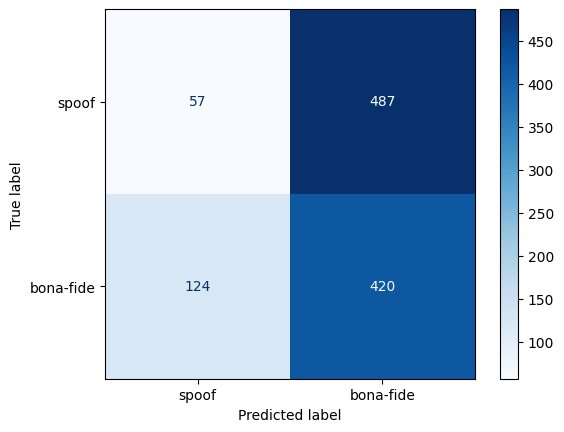

In [62]:

#USE THIS TO PREPROCESS,EXTRACT AND GENERATE CSV 

from pathlib import Path
import numpy as np
import librosa
from tqdm import tqdm

def extract_and_save_all(input_root, output_root, sr=22050, target_duration=6.0,
                         apply_preemphasis=False, coef=0.5, normalise='rms'):
    input_root = Path(input_root)
    output_root = Path(output_root)

    for split in ["testing"]:
        for label_dir in ["real", "fake"]:
            input_folder = input_root / split / label_dir
            output_base = output_root / f"preprocessed_{split}" / label_dir

            print(f"Looking in: {input_folder}")
            wav_files = sorted(list(input_folder.glob("*.wav")))
            print(f"Found {len(wav_files)} files in '{split}/{label_dir}'")

            for wav_file in tqdm(wav_files, desc=f"Processing {label_dir}"):
                try:
                    y, _ = librosa.load(wav_file, sr=sr)
                    y = preprocess_audio(y, sr, target_duration, apply_preemphasis, coef, normalise)

                    clean_name = wav_file.stem.split(".")[0] + ".npy"

                    feature_dict = {
                        "mel_spectrogram": librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128),
                        "mfcc": librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20),
                        "chroma": librosa.feature.chroma_stft(y=y, sr=sr),
                        "tonnetz": librosa.feature.tonnetz(y=librosa.effects.harmonic(y), sr=sr),
                        "spectral_contrast": librosa.feature.spectral_contrast(y=y, sr=sr),
                        "spectral_centroid": librosa.feature.spectral_centroid(y=y, sr=sr),
                        "pitch": librosa.yin(y, fmin=50, fmax=300, sr=sr),
                        "energy": librosa.feature.rms(y=y),
                        "zcr": librosa.feature.zero_crossing_rate(y=y),
                        "onset_strength": librosa.onset.onset_strength(y=y, sr=sr)
                    }

                    for feature_name, data in feature_dict.items():
                        out_path = output_base / feature_name / clean_name
                        out_path.parent.mkdir(parents=True, exist_ok=True)
                        np.save(out_path, data.astype(np.float32))

                except Exception as e:
                    print(f"[ERROR] {wav_file.name}: {e}")

extract_and_save_all(
    input_root="datasets/evaluation/for-2sec/for-2seconds",
    output_root="datasets/evaluation/for-2sec/for-2seconds",
    sr=16000, target_duration=6.0
)

import pandas as pd
from pathlib import Path


def generate_test_meta_csv(real_dir, fake_dir, save_path):
    entries = []
    for path in sorted(Path(real_dir).glob("*.wav")):
        base = path.name.split(".")[0]  
        entries.append({"file": base + ".npy", "label": 1})
    for path in sorted(Path(fake_dir).glob("*.wav")):
        base = path.name.split(".")[0]
        entries.append({"file": base + ".npy", "label": 0})
    pd.DataFrame(entries).to_csv(save_path, index=False)



generate_test_meta_csv(
    real_dir="datasets/evaluation/for-2sec/for-2seconds/testing/real",
    fake_dir="datasets/evaluation/for-2sec/for-2seconds/testing/fake",
    save_path="datasets/evaluation/for-2sec/for-2seconds/test_meta.csv"
)

import torch
from torch.utils.data import Dataset
import numpy as np
import os
import pandas as pd
import torch.nn.functional as F

class AudioFeatureDataset(Dataset):
    def __init__(self, meta_csv, feature_root,
                 features=['chroma', 'energy', 'mel_spectrogram', 'mfcc',
                           'onset_strength', 'pitch', 'spectral_centroid',
                           'spectral_contrast', 'tonnetz', 'zcr'],
                 target_shape=(128, 259)):
        self.df = pd.read_csv(meta_csv)
        self.df["label"] = self.df["label"].astype(int) 
        self.feature_root = feature_root
        self.features = features
        self.label_map = {1: 1, 0: 0}
        self.target_shape = target_shape

    def __len__(self):
        return len(self.df)

    def _pad_or_resize(self, tensor, target_shape):
        h, w = tensor.shape
        pad_h = target_shape[0] - h
        pad_w = target_shape[1] - w

        if pad_h < 0 or pad_w < 0:
            return tensor[:target_shape[0], :target_shape[1]]
        return F.pad(tensor, (0, pad_w, 0, pad_h))

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        label_raw = row["label"]
        if label_raw not in self.label_map:
            raise ValueError(f"Unknown label: '{label_raw}' at idx {idx}")
        label = self.label_map[label_raw]

        label_dir = "real" if label == 1 else "fake"

        # Construct the file path
        file_id = row["file"]
        feature_arrays = []
        for feat in self.features:
            path = os.path.join(self.feature_root, label_dir, feat, file_id)
            if not os.path.exists(path):
                raise FileNotFoundError(f"Missing file: {path}")

            arr = np.load(path)
            tensor = torch.tensor(arr, dtype=torch.float32)
            if tensor.dim() == 1:
                tensor = tensor.unsqueeze(0)
            tensor = self._pad_or_resize(tensor, self.target_shape)
            feature_arrays.append(tensor)

        return (*feature_arrays, torch.tensor(label, dtype=torch.float32))



for_2sec_test_dataset = AudioFeatureDataset(
    meta_csv="datasets/evaluation/for-2sec/for-2seconds/test_meta.csv",
    feature_root="datasets/evaluation/for-2sec/for-2seconds/preprocessed_testing",
    features=[
        'mfcc', 'chroma', 'tonnetz', 'spectral_contrast',
        'pitch', 'energy', 'zcr', 'onset_strength', 'spectral_centroid', 'mel_spectrogram'
    ]
)

evaluate_on_test_set(model, for_2sec_test_dataset)


Evaluation of ASVspoof2019 LA dataset

In [63]:
import pandas as pd
from pathlib import Path

def make_la_eval_metadata(
    protocol_path: str,
    audio_dir: str,
    output_csv: str
):
    protocol = Path(protocol_path)
    if not protocol.exists():
        raise FileNotFoundError(f"Cannot find protocol file: {protocol}")

    entries = []
    with protocol.open('r') as f:
        for line in f:
            cols = line.strip().split()
            if len(cols) != 5:
                continue
            speaker, audio_id, system_id, dash, key = cols
            filename = audio_id + ".flac"
            audio_path = Path(audio_dir) / filename
            if not audio_path.exists():
                print(f"[WARNING] Audio missing: {audio_path}")
                continue
            label = 1 if key.lower() == "bonafide" else 0
            entries.append({
                "file":    filename,
                "speaker": speaker,
                "label":   label
            })

    df = pd.DataFrame(entries, columns=["file","speaker","label"])
    df.to_csv(output_csv, index=False)
    print(f"Saved {len(df)} rows to {output_csv}")


make_la_eval_metadata(
    protocol_path="datasets/evaluation/LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.eval.trl.txt",
    audio_dir="datasets/evaluation/LA/ASVspoof2019_LA_eval/flac",          
    output_csv="datasets/evaluation/LA/LA_eval_meta.csv"
)



Saved 71237 rows to datasets/evaluation/LA/LA_eval_meta.csv


In [ ]:
import time
import numpy as np
import librosa
import pandas as pd
from pathlib import Path
from tqdm import tqdm

def extract_and_save_la_features_with_eta(
    meta_csv: str,
    audio_root: str,
    output_root: str,
    sr: int = 16000,
    target_duration: float = 6.0,
    apply_preemphasis: bool = False,
    coef: float = 0.5,
    normalise: str = "rms",
):
    df = pd.read_csv(meta_csv)     
    audio_root  = Path(audio_root)
    output_base = Path(output_root) / "preprocessed_eval"

    total_files = len(df)
    start_time = time.time()

    pbar = tqdm(df.iterrows(),
                total=total_files,
                desc="Extract LA features",
                unit="file")

    for idx, (_, row) in enumerate(pbar):
        filename = row["file"]
        label_dir = "real" if row["label"] == 1 else "fake"
        in_path   = audio_root / filename

        y, _ = librosa.load(str(in_path), sr=sr)
        y = preprocess_audio(y, sr, target_duration,
                             apply_preemphasis, coef, normalise)

        feats = {
            "mel_spectrogram":   librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128),
            "mfcc":              librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20),
            "chroma":            librosa.feature.chroma_stft(y=y, sr=sr),
            "tonnetz":           librosa.feature.tonnetz(y=librosa.effects.harmonic(y), sr=sr),
            "spectral_contrast": librosa.feature.spectral_contrast(y=y, sr=sr),
            "spectral_centroid": librosa.feature.spectral_centroid(y=y, sr=sr),
            "pitch":             librosa.yin(y, fmin=50, fmax=300, sr=sr),
            "energy":            librosa.feature.rms(y=y),
            "zcr":               librosa.feature.zero_crossing_rate(y=y),
            "onset_strength":    librosa.onset.onset_strength(y=y, sr=sr)
        }

        npy_name = Path(filename).stem + ".npy"
        for feat_name, arr in feats.items():
            out_dir = output_base / label_dir / feat_name
            out_dir.mkdir(parents=True, exist_ok=True)
            np.save(out_dir / npy_name, arr.astype(np.float32))

        elapsed = time.time() - start_time
        avg_per_file = elapsed / (idx + 1)
        remaining = total_files - (idx + 1)
        eta = remaining * avg_per_file
        pbar.set_postfix_str(f"ETA {eta:.0f}s")

    pbar.close()

extract_and_save_la_features_with_eta(
    meta_csv="datasets/evaluation/LA/LA_eval_meta.csv",
    audio_root="datasets/evaluation/LA/ASVspoof2019_LA_eval/flac",
    output_root="datasets/evaluation/LA",
    sr=22050,
    target_duration=6.0,
    apply_preemphasis=False,
    coef=0.5,
    normalise="rms",
)



Extract LA features:  70%|███████   | 49890/71237 [4:33:18<1:51:54,  3.18file/s, ETA 7017s]  

In [ ]:
import torch
from torch.utils.data import Dataset
import numpy as np
from pathlib import Path
import pandas as pd
import torch.nn.functional as F

class AudioFeatureDataset(Dataset):
    def __init__(self, meta_csv, feature_root,
                 features=[
                     'mel_spectrogram','mfcc','chroma','tonnetz',
                     'spectral_contrast','spectral_centroid',
                     'pitch','energy','zcr','onset_strength'
                 ],
                 target_shape=(128, 259)):
                
        self.df = pd.read_csv(meta_csv)
        self.feature_root = Path(feature_root)
        self.features = features
        self.target_shape = target_shape
        self.df["label"] = self.df["label"].astype(int)

    def __len__(self):
        return len(self.df)

    def _pad_or_resize(self, tensor, target_shape):
        h, w = tensor.shape
        th, tw = target_shape
        if th is None: th = h
        if tw is None: tw = w
        pad_h = th - h
        pad_w = tw - w
        if pad_h < 0 or pad_w < 0:
            return tensor[:th, :tw]
        return F.pad(tensor, (0, pad_w, 0, pad_h))

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        file_id = Path(row["file"]).stem + ".npy"
        label_dir = "real" if row["label"] == 1 else "fake"

        feature_tensors = []
        for feat in self.features:
            path = self.feature_root / "preprocessed_eval" / label_dir / feat / file_id
            if not path.exists():
                raise FileNotFoundError(f"Missing {path}")
            arr = np.load(path)
            t = torch.tensor(arr, dtype=torch.float32)
            if t.dim() == 1:
                t = t.unsqueeze(0)
            t = self._pad_or_resize(t, self.target_shape)
            feature_tensors.append(t)

        return (*feature_tensors, torch.tensor(row["label"], dtype=torch.float32))


In [ ]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, roc_curve
)
from scipy.optimize import brentq
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
import numpy as np
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm

def evaluate_on_test_set(model, test_dataset,
                         batch_size=32,
                         device='cuda' if torch.cuda.is_available() else 'cpu'):
    loader = DataLoader(test_dataset, batch_size=batch_size)
    model.eval()
    model.to(device)

    all_probs, all_preds, all_labels = [], [], []

    with torch.no_grad():
        for batch in tqdm(loader, desc="Testing"):
            *features, labels = batch
            features = [f.to(device) for f in features]
            labels = labels.to(device).unsqueeze(1)
            outputs = model(*features)
            probs = torch.sigmoid(outputs).cpu().numpy().squeeze()
            preds = (probs > 0.5).astype(int)

            all_probs.extend(probs.tolist())
            all_preds.extend(preds.tolist())
            all_labels.extend(labels.cpu().numpy().astype(int).tolist())

    all_labels = np.array(all_labels)
    all_preds  = np.array(all_preds)
    all_probs  = np.array(all_probs)

    # compute metrics
    acc  = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, zero_division=0)
    rec  = recall_score(all_labels, all_preds, zero_division=0)
    f1   = f1_score(all_labels, all_preds, zero_division=0)
    auc  = roc_auc_score(all_labels, all_probs)

    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    eer = brentq(lambda x: 1.-x - interp1d(fpr, tpr)(x), 0., 1.)

    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1 Score:  {f1:.4f}")
    print(f"AUC:       {auc:.4f}")
    print(f"EER:       {eer:.4f}")

    # confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(cm, display_labels=["spoof","bona-fide"])
    disp.plot(cmap=plt.cm.Blues)
    plt.show()


In [ ]:

model = AudioDeepfakeFusionModel()
model.load_state_dict(
    torch.load("df_model.pth", map_location="cpu")
)

dataset = AudioFeatureDataset(
    meta_csv="datasets/evaluation/LA/LA_eval_meta.csv",
    feature_root="datasets/evaluation/LA",
    features=[
        'mfcc', 'chroma', 'tonnetz', 'spectral_contrast',
        'pitch', 'energy', 'zcr', 'onset_strength', 'spectral_centroid', 'mel_spectrogram'
    ]
)


import torch
from torch.utils.data import DataLoader

debug_loader = DataLoader(dataset, batch_size=32, shuffle=False)
batch = next(iter(debug_loader))

evaluate_on_test_set(model, dataset, batch_size=32)


C:\Users\Aadil\AppData\Local\Temp\ipykernel_33632\2307706330.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load("df_model.pth", map_location="cpu")


FileNotFoundError: Missing datasets\evaluation\LA\preprocessed_eval\fake\mfcc\LA_E_1611480.npy